# How You Can Avoid Car Accident in 2020
see post on medium.com:
https://medium.com/@RonghuiZhou/how-you-can-avoid-car-accident-in-2020-c9626c9b6f68


### Use LR/KNN/Decision Tree/Random Forest classification algorithms from sklearn to predict the accident severity

Due to the limit of computer capacity, I am focusing on Montgomery County in the State of Pennsylvania. I will only select a few features I believe are more relavant to severity. Categorical data will be treated with Pandas get_dummies method. Rows with missing values will be dropped.

### Data source
https://www.kaggle.com/sobhanmoosavi/us-accidents


### Acknowledgements

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.


####  Author
Ronghui Zhou, zhou.uf@gmail.com
https://github.com/RonghuiZhou

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Step 1. Import libraries

In [8]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import dependencies
import os
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
# from config import username, password
import time
from pathlib import Path
import pickle
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble.forest import RandomForestClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
import seaborn as sns


from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

### Step 2. Import the dataset

In [9]:
# Import the data
df = pd.read_csv('./resources/US_Accidents_June20.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513740 entries, 0 to 3513739
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

### Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

In [10]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513740 entries, 0 to 3513739
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               int64         
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

### Step 4. Deal with outliers

#### A. Drop rows with negative time_duration

In [11]:
# Check if there is any negative time_duration values
df[td][df[td]<=0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
860988    -12.0
861024    -31.0
861041     -0.0
861475    -14.0
861494     -0.0
861495    -30.0
1497823   -30.0
1497824   -31.0
2234574   -30.0
2234659   -30.0
2234660   -31.0
3104618   -34.0
3105094    -7.0
3105097    -7.0
3232859   -31.0
Name: Time_Duration(min), dtype: float64

In [12]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513718 entries, 0 to 3513739
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [13]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

### Step 4. Deal with outliers

#### B. Fill outliers with median values

In [14]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513718 entries, 0 to 3513739
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [15]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 33804.0 minutes or 563 hours or 23 days; Min to clear an accident td: 1.0 minutes.


In [16]:
# Export the data
# df.to_csv('./US_Accidents_May19_clean.csv',index=False)

### Step 5. Select a list of features for machine learning algorithms

 Only select relavant columns without overwhelming the computer

In [17]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour,Weekday,Time_Duration(min)
0,A-1,MapQuest,201.0,3.0,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,Night,Night,Night,2016.0,Feb,8.0,5.0,Mon,314.0
1,A-2,MapQuest,201.0,2.0,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,Night,Night,Day,2016.0,Feb,8.0,6.0,Mon,30.0
2,A-3,MapQuest,201.0,2.0,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Night,Night,Day,Day,2016.0,Feb,8.0,6.0,Mon,30.0
3,A-4,MapQuest,201.0,3.0,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,Day,Day,Day,2016.0,Feb,8.0,7.0,Mon,30.0
4,A-5,MapQuest,201.0,2.0,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Day,Day,Day,Day,2016.0,Feb,8.0,7.0,Mon,30.0


In [18]:
# Set the list of features to include in Machine Learning 
# 'Severity', 
# 'Start_Time', 
# 'City', 
# 'County', 
# 'State', 
# 'Zipcode', 
# 'Temperature(F)
# 'Visibility(mi)', 
# 'Precipitation(in)', 
# 'Amenity', 
# 'Bump', 
# 'Crossing', 
# 'Give_Way', 
# 'Junction', 
# 'No_Exit', 
# 'Railway', 
# 'Roundabout', 
# 'Station', 
# 'Stop', 
# 'Traffic_Calming', 
# 'Traffic_Signal', 
# 'Turning_Loop', 
# 'Month', 
# 'Hour', 
# 'Weekday' 
# ID



feature_lst=['ID', 'Severity', 'Start_Time', 'City', 'County', 'State', 'Zipcode', 'Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Month', 'Hour', 'Weekday' ]

In [19]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513718 entries, 0 to 3513739
Data columns (total 26 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ID                 object        
 1   Severity           float64       
 2   Start_Time         datetime64[ns]
 3   City               object        
 4   County             object        
 5   State              object        
 6   Zipcode            object        
 7   Temperature(F)     float64       
 8   Visibility(mi)     float64       
 9   Precipitation(in)  float64       
 10  Amenity            float64       
 11  Bump               float64       
 12  Crossing           float64       
 13  Give_Way           float64       
 14  Junction           float64       
 15  No_Exit            float64       
 16  Railway            float64       
 17  Roundabout         float64       
 18  Station            float64       
 19  Stop               float64       
 20  Traffic_Calming    float

In [20]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_Features_Selected.csv',index=False)

### Step 6. Drop rows with missing values

In [21]:
# Check missing values
df_sel.isnull().mean()

ID                   0.000167
Severity             0.000167
Start_Time           0.000167
City                 0.000199
County               0.000167
State                0.000167
Zipcode              0.000471
Temperature(F)       0.018868
Visibility(mi)       0.021749
Precipitation(in)    0.576623
Amenity              0.000167
Bump                 0.000167
Crossing             0.000167
Give_Way             0.000167
Junction             0.000167
No_Exit              0.000167
Railway              0.000167
Roundabout           0.000167
Station              0.000167
Stop                 0.000167
Traffic_Calming      0.000167
Traffic_Signal       0.000167
Turning_Loop         0.000167
Month                0.000167
Hour                 0.000167
Weekday              0.000167
dtype: float64

In [22]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(1472569, 26)

In [23]:
# Export the data with selected features
df_sel.to_csv('./US_Accidents_Features_Selected.csv',index=False)

### Step 7. Select the state of interest: CA; and County of interest: Los Angeles
   

Due to the limitation of personal laptop, the whole US dataset is too big to handle

In [24]:
# Import data if it was already exported based on previous work
# df_sel=pd.read_csv('./US_Accidents_May19_clean_sel_dropna.csv')

trydf = df_sel.copy()
trydf



,ID,Severity,Start_Time,City,County,State,Zipcode,Temperature(F),Visibility(mi),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Month,Hour,Weekday
0,A-1,3.0,2016-02-08 05:46:00,Dayton,Montgomery,OH,45424,36.9,10.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,5.0,Mon
1,A-2,2.0,2016-02-08 06:07:59,Reynoldsburg,Franklin,OH,43068-3402,37.9,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,6.0,Mon
5,A-6,3.0,2016-02-08 07:44:26,Westerville,Franklin,OH,43081,37.9,7.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,7.0,Mon
9,A-10,3.0,2016-02-08 08:10:04,Westerville,Franklin,OH,43081,37.4,3.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,8.0,Mon
11,A-12,3.0,2016-02-08 08:21:27,Reynoldsburg,Franklin,OH,43068,37.4,3.0,0.02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,8.0,Mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513735,A-3513776,2.0,2019-08-23 18:03:25,Riverside,Riverside,CA,92501,86.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,18.0,Fri
3513736,A-3513777,2.0,2019-08-23 19:11:30,San Diego,San Diego,CA,92108,70.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,19.0,Fri
3513737,A-3513778,2.0,2019-08-23 19:00:21,Orange,Orange,CA,92866,73.0,10.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,19.0,Fri
3513738,A-3513779,2.0,2019-08-23 19:00:21,Culver City,Los Angeles,CA,90230,71.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,19.0,Fri


In [25]:
# Set state
state='CA'

# select the state of California
df_state=trydf.loc[trydf.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326983 entries, 958 to 3513739
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 326983 non-null  object        
 1   Severity           326983 non-null  float64       
 2   Start_Time         326983 non-null  datetime64[ns]
 3   City               326983 non-null  object        
 4   County             326983 non-null  object        
 5   Zipcode            326983 non-null  object        
 6   Temperature(F)     326983 non-null  float64       
 7   Visibility(mi)     326983 non-null  float64       
 8   Precipitation(in)  326983 non-null  float64       
 9   Amenity            326983 non-null  float64       
 10  Bump               326983 non-null  float64       
 11  Crossing           326983 non-null  float64       
 12  Give_Way           326983 non-null  float64       
 13  Junction           326983 non-null  float

In [26]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=trydf, hue='State', legend=False, s=20)
plt.show()

ValueError: Could not interpret input 'Start_Lng'

In [27]:
# Set county
# county='Los Angeles'

# # Select the county of LA 
# df_county=df_state.loc[df_state.County==county].copy()
# df_county.drop('County',axis=1, inplace=True)
# df_county.info()

#selecting zipcode 90022 for testing purposes
zc='90022'

# Select the county of LA 
df_county=df_state.loc[df_state.Zipcode==zc].copy()
df_county.drop('Zipcode',axis=1, inplace=True)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, 58251 to 3505811
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 805 non-null    object        
 1   Severity           805 non-null    float64       
 2   Start_Time         805 non-null    datetime64[ns]
 3   City               805 non-null    object        
 4   County             805 non-null    object        
 5   Temperature(F)     805 non-null    float64       
 6   Visibility(mi)     805 non-null    float64       
 7   Precipitation(in)  805 non-null    float64       
 8   Amenity            805 non-null    float64       
 9   Bump               805 non-null    float64       
 10  Crossing           805 non-null    float64       
 11  Give_Way           805 non-null    float64       
 12  Junction           805 non-null    float64       
 13  No_Exit            805 non-null    float64       
 14  Ra

In [28]:
# Map of accidents, color code by city

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_county, hue='City', legend=False, s=20)
plt.show()

ValueError: Could not interpret input 'Start_Lng'

In [29]:
df_state.to_csv('./Accident_California_Only_Features_Selected.csv',index=False)

### Step 8. Deal with categorical data: pd.get_dummies()


# Generate dummies for categorical data
df_county_dummy = pd.get_dummies(df_county,drop_first=True)

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

df_county_dummy.info()

### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [30]:
trydf2 = pd.read_csv('Accident_California_Only_Features_Selected.csv')

trydf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326983 entries, 0 to 326982
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 326983 non-null  object 
 1   Severity           326983 non-null  float64
 2   Start_Time         326983 non-null  object 
 3   City               326983 non-null  object 
 4   County             326983 non-null  object 
 5   Zipcode            326983 non-null  object 
 6   Temperature(F)     326983 non-null  float64
 7   Visibility(mi)     326983 non-null  float64
 8   Precipitation(in)  326983 non-null  float64
 9   Amenity            326983 non-null  float64
 10  Bump               326983 non-null  float64
 11  Crossing           326983 non-null  float64
 12  Give_Way           326983 non-null  float64
 13  Junction           326983 non-null  float64
 14  No_Exit            326983 non-null  float64
 15  Railway            326983 non-null  float64
 16  Ro

In [31]:
trydf2.dtypes

ID                    object
Severity             float64
Start_Time            object
City                  object
County                object
Zipcode               object
Temperature(F)       float64
Visibility(mi)       float64
Precipitation(in)    float64
Amenity              float64
Bump                 float64
Crossing             float64
Give_Way             float64
Junction             float64
No_Exit              float64
Railway              float64
Roundabout           float64
Station              float64
Stop                 float64
Traffic_Calming      float64
Traffic_Signal       float64
Turning_Loop         float64
Month                 object
Hour                 float64
Weekday               object
dtype: object

In [32]:
trydf2['Severity'] = pd.to_numeric(trydf2['Severity'], downcast='integer')

In [33]:
checktypesdf = trydf2.copy()

In [34]:
checktypesdf['Hour'] = pd.to_numeric(checktypesdf['Hour'], downcast='float')

In [35]:
checktypesdf.dtypes

ID                    object
Severity                int8
Start_Time            object
City                  object
County                object
Zipcode               object
Temperature(F)       float64
Visibility(mi)       float64
Precipitation(in)    float64
Amenity              float64
Bump                 float64
Crossing             float64
Give_Way             float64
Junction             float64
No_Exit              float64
Railway              float64
Roundabout           float64
Station              float64
Stop                 float64
Traffic_Calming      float64
Traffic_Signal       float64
Turning_Loop         float64
Month                 object
Hour                 float32
Weekday               object
dtype: object

In [36]:
checktypesdf.head()

,ID,Severity,Start_Time,City,County,Zipcode,Temperature(F),Visibility(mi),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Month,Hour,Weekday
0,A-959,3,2016-06-22 23:26:28,Fairfield,Solano,94534,55.9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jun,23.0,Wed
1,A-969,3,2016-06-23 03:04:28,Fairfield,Solano,94534,54.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jun,3.0,Thu
2,A-1648,3,2016-06-29 10:47:51,Hayward,Alameda,94541,60.1,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Jun,10.0,Wed
3,A-2914,2,2016-07-13 11:42:58,Fremont,Alameda,94555,73.9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jul,11.0,Wed
4,A-2915,3,2016-07-13 11:42:20,Hayward,Alameda,94545,73.9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jul,11.0,Wed


In [37]:
feature_lst=['City', 'County', 'Zipcode', 'Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Month', 'Hour', 'Weekday' ]

dummifydf=checktypesdf[feature_lst].copy()
dummifydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326983 entries, 0 to 326982
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               326983 non-null  object 
 1   County             326983 non-null  object 
 2   Zipcode            326983 non-null  object 
 3   Temperature(F)     326983 non-null  float64
 4   Visibility(mi)     326983 non-null  float64
 5   Precipitation(in)  326983 non-null  float64
 6   Amenity            326983 non-null  float64
 7   Bump               326983 non-null  float64
 8   Crossing           326983 non-null  float64
 9   Give_Way           326983 non-null  float64
 10  Junction           326983 non-null  float64
 11  No_Exit            326983 non-null  float64
 12  Railway            326983 non-null  float64
 13  Roundabout         326983 non-null  float64
 14  Station            326983 non-null  float64
 15  Stop               326983 non-null  float64
 16  Tr

In [38]:
dummifydf.dtypes

City                  object
County                object
Zipcode               object
Temperature(F)       float64
Visibility(mi)       float64
Precipitation(in)    float64
Amenity              float64
Bump                 float64
Crossing             float64
Give_Way             float64
Junction             float64
No_Exit              float64
Railway              float64
Roundabout           float64
Station              float64
Stop                 float64
Traffic_Calming      float64
Traffic_Signal       float64
Turning_Loop         float64
Month                 object
Hour                 float32
Weekday               object
dtype: object

In [39]:
dummifydf['Zipcode'] = dummifydf['Zipcode'].str[:5]

In [40]:
dummifydf.rename(columns = {'Start_Lat':'Latitude', 'Start_Lng':'Longitude', 'Temperature(F)': 'Temperature', 'Wind_Speed(mph)': 'Wind_Speed_mph',
                              'Visibility(mi)': 'Visibility_miles', 'Precipitation(in)': 'Precipitation_inches', 'Bump': 'Speed_Bump', 'Crossing': 'Cross_Walk', 
                              'Give_Way': 'Yield_Sign', 'Junction': 'Intersection', 'Stop': 'Stop_Sign', 'Traffic_Calming': 'Traffic', 'Traffic_Signal': 'Traffic_Light', 
                              }, inplace = True) 

In [41]:
dummifydf.head()

,City,County,Zipcode,Temperature,Visibility_miles,Precipitation_inches,Amenity,Speed_Bump,Cross_Walk,Yield_Sign,Intersection,No_Exit,Railway,Roundabout,Station,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,Month,Hour,Weekday
0,Fairfield,Solano,94534,55.9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jun,23.0,Wed
1,Fairfield,Solano,94534,54.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jun,3.0,Thu
2,Hayward,Alameda,94541,60.1,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Jun,10.0,Wed
3,Fremont,Alameda,94555,73.9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jul,11.0,Wed
4,Hayward,Alameda,94545,73.9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jul,11.0,Wed


In [42]:
dummifydf.dtypes

City                     object
County                   object
Zipcode                  object
Temperature             float64
Visibility_miles        float64
Precipitation_inches    float64
Amenity                 float64
Speed_Bump              float64
Cross_Walk              float64
Yield_Sign              float64
Intersection            float64
No_Exit                 float64
Railway                 float64
Roundabout              float64
Station                 float64
Stop_Sign               float64
Traffic                 float64
Traffic_Light           float64
Turning_Loop            float64
Month                    object
Hour                    float32
Weekday                  object
dtype: object

In [43]:
dummifydf['Zipcode'] = dummifydf['Zipcode'].astype(np.int32, errors='raise')


In [44]:
# Generate dummies for categorical data
dum9_df = pd.get_dummies(data=dummifydf, columns= [ 
'City', 
'County', 
'Zipcode', 
'Month', 
'Hour', 
'Weekday'
])

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

dum9_df.info()

# 'Amenity', 
# 'Bump', 
# 'Crossing', 
# 'Give_Way', 
# 'Junction', 
# 'No_Exit', 
# 'Railway', 
# 'Roundabout', 
# 'Station', 
# 'Stop', 
# 'Traffic_Calming', 
# 'Traffic_Signal', 
# 'Turning_Loop',

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326983 entries, 0 to 326982
Columns: 2579 entries, Temperature to Weekday_Wed
dtypes: float64(16), uint8(2563)
memory usage: 839.1 MB


In [45]:
for row in dum9_df.columns.to_list():
    print(row)

Temperature
Visibility_miles
Precipitation_inches
Amenity
Speed_Bump
Cross_Walk
Yield_Sign
Intersection
No_Exit
Railway
Roundabout
Station
Stop_Sign
Traffic
Traffic_Light
Turning_Loop
City_Acampo
City_Acton
City_Agoura Hills
City_Aguanga
City_Ahwahnee
City_Alameda
City_Alamo
City_Albany
City_Albion
City_Alderpoint
City_Alhambra
City_Aliso Viejo
City_Alpine
City_Alpine Meadows
City_Alta
City_Alturas
City_Alviso
City_American Canyon
City_Anaheim
City_Anaheim-Santa Ana-Garden Grove
City_Anderson
City_Angels Camp
City_Angelus Oaks
City_Angwin
City_Annapolis
City_Antioch
City_Anza
City_Applegate
City_Aptos
City_Arbuckle
City_Arcadia
City_Arcata
City_Armona
City_Arnold
City_Aromas
City_Arroyo Grande
City_Artesia
City_Arvin
City_Atascadero
City_Atherton
City_Atwater
City_Auberry
City_Auburn
City_Avenal
City_Azusa
City_Badger
City_Bakersfield
City_Baldwin Park
City_Ballico
City_Bangor
City_Banning
City_Barstow
City_Bass Lake
City_Bay Point
City_Bayside
City_Beaumont
City_Beckwourth
City_Belden

Zipcode_95329
Zipcode_95330
Zipcode_95333
Zipcode_95334
Zipcode_95335
Zipcode_95336
Zipcode_95337
Zipcode_95338
Zipcode_95340
Zipcode_95341
Zipcode_95345
Zipcode_95346
Zipcode_95348
Zipcode_95350
Zipcode_95351
Zipcode_95354
Zipcode_95355
Zipcode_95356
Zipcode_95357
Zipcode_95358
Zipcode_95360
Zipcode_95361
Zipcode_95363
Zipcode_95364
Zipcode_95365
Zipcode_95366
Zipcode_95367
Zipcode_95368
Zipcode_95369
Zipcode_95370
Zipcode_95372
Zipcode_95374
Zipcode_95376
Zipcode_95377
Zipcode_95379
Zipcode_95380
Zipcode_95382
Zipcode_95383
Zipcode_95385
Zipcode_95386
Zipcode_95388
Zipcode_95389
Zipcode_95391
Zipcode_95401
Zipcode_95403
Zipcode_95404
Zipcode_95405
Zipcode_95407
Zipcode_95409
Zipcode_95410
Zipcode_95412
Zipcode_95415
Zipcode_95417
Zipcode_95420
Zipcode_95421
Zipcode_95422
Zipcode_95423
Zipcode_95425
Zipcode_95426
Zipcode_95427
Zipcode_95428
Zipcode_95429
Zipcode_95432
Zipcode_95436
Zipcode_95437
Zipcode_95439
Zipcode_95441
Zipcode_95442
Zipcode_95443
Zipcode_95444
Zipcode_95445
Zipcod

In [46]:
dumCAdf = dum9_df.copy()

dumCAdf


,Temperature,Visibility_miles,Precipitation_inches,Amenity,Speed_Bump,Cross_Walk,Yield_Sign,Intersection,No_Exit,Railway,Roundabout,Station,Stop_Sign,Traffic,Traffic_Light,Turning_Loop,City_Acampo,City_Acton,City_Agoura Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso Viejo,City_Alpine,City_Alpine Meadows,City_Alta,City_Alturas,City_Alviso,City_American Canyon,City_Anaheim,City_Anaheim-Santa Ana-Garden Grove,City_Anderson,City_Angels Camp,City_Angelus Oaks,City_Angwin,City_Annapolis,City_Antioch,City_Anza,City_Applegate,City_Aptos,City_Arbuckle,City_Arcadia,City_Arcata,City_Armona,City_Arnold,City_Aromas,City_Arroyo Grande,City_Artesia,City_Arvin,City_Atascadero,City_Atherton,City_Atwater,City_Auberry,City_Auburn,City_Avenal,City_Azusa,City_Badger,City_Bakersfield,City_Baldwin Park,City_Ballico,City_Bangor,City_Banning,City_Barstow,City_Bass Lake,City_Bay Point,City_Bayside,City_Beaumont,City_Beckwourth,City_Belden,City_Bell,City_Bell Canyon,City_Bell Gardens,City_Bella Vista,City_Bellflower,City_Belmont,City_Belvedere Tiburon,City_Ben Lomond,City_Benicia,City_Benton,City_Berkeley,City_Berry Creek,City_Bethel Island,City_Beverly Hills,City_Big Bar,City_Big Bear City,City_Big Bear Lake,City_Big Pine,City_Big Sur,City_Biggs,City_Birds Landing,City_Bishop,City_Blairsden Graeagle,City_Bloomington,City_Blue Jay,City_Blue Lake,...,Zipcode_96061,Zipcode_96062,Zipcode_96064,Zipcode_96065,Zipcode_96067,Zipcode_96069,Zipcode_96071,Zipcode_96073,Zipcode_96075,Zipcode_96076,Zipcode_96080,Zipcode_96086,Zipcode_96087,Zipcode_96088,Zipcode_96091,Zipcode_96093,Zipcode_96094,Zipcode_96096,Zipcode_96097,Zipcode_96101,Zipcode_96103,Zipcode_96104,Zipcode_96105,Zipcode_96106,Zipcode_96107,Zipcode_96108,Zipcode_96109,Zipcode_96111,Zipcode_96113,Zipcode_96114,Zipcode_96117,Zipcode_96118,Zipcode_96119,Zipcode_96120,Zipcode_96121,Zipcode_96122,Zipcode_96123,Zipcode_96124,Zipcode_96125,Zipcode_96126,Zipcode_96128,Zipcode_96129,Zipcode_96130,Zipcode_96132,Zipcode_96133,Zipcode_96134,Zipcode_96137,Zipcode_96140,Zipcode_96141,Zipcode_96142,Zipcode_96143,Zipcode_96145,Zipcode_96146,Zipcode_96148,Zipcode_96150,Zipcode_96161,Zipcode_96162,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Hour_0.0,Hour_1.0,Hour_2.0,Hour_3.0,Hour_4.0,Hour_5.0,Hour_6.0,Hour_7.0,Hour_8.0,Hour_9.0,Hour_10.0,Hour_11.0,Hour_12.0,Hour_13.0,Hour_14.0,Hour_15.0,Hour_16.0,Hour_17.0,Hour_18.0,Hour_19.0,Hour_20.0,Hour_21.0,Hour_22.0,Hour_23.0,Weekday_Fri,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed
0,55.9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,54.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,60.1,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,73.9,10.0,0.0,0.0,0.0,0.0,

### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [47]:
target_sev = checktypesdf['Severity'].copy()
target_sev

0         3
1         3
2         3
3         2
4         3
         ..
326978    2
326979    2
326980    2
326981    2
326982    2
Name: Severity, Length: 326983, dtype: int8

In [48]:
# Assign the data
df=dumCAdf

# Set the target for the prediction
target=target_sev


# Create arrays for the features and the response variable

# set X and y
y = target
X = df

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78, train_size=0.80)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(261586, 2579)
(65397, 2579)
(261586,)
(65397,)


In [50]:
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [51]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm A. Logistic regression              

In [53]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

C:\Users\Rob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[Logistic regression algorithm] accuracy_score: 0.817.


In [54]:
# Saving model to disk
pickle.dump(lr, open('logistic_regression_modelv2.pkl','wb'))

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### KNN with 6 neighors

In [ ]:
# # Create a k-NN classifier with 6 neighbors
# knn = KNeighborsClassifier(n_neighbors=100)

# # Fit the classifier to the data
# knn.fit(X_train,y_train)

# # Predict the labels for the training data X
# y_pred = knn.predict(X_test)

# # Get the accuracy score
# acc=accuracy_score(y_test, y_pred)

# # Append to the accuracy list
# accuracy_lst.append(acc)

# print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
# print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### Optmize the number of neighors: plot the accuracy versus number of neighbors

In [ ]:
# # Setup arrays to store train and test accuracies
# neighbors = np.arange(1, 100)
# train_accuracy = np.empty(len(neighbors))
# test_accuracy = np.empty(len(neighbors))

# # Loop over different values of k
# for i, n_neighbor in enumerate(neighbors):
    
#     # Setup a k-NN Classifier with n_neighbor
#     knn = KNeighborsClassifier(n_neighbors=n_neighbor)

#     # Fit the classifier to the training data
#     knn.fit(X_train,y_train)
    
#     #Compute accuracy on the training set
#     train_accuracy[i] = knn.score(X_train, y_train)

#     #Compute accuracy on the testing set
#     test_accuracy[i] = knn.score(X_test, y_test)

# # Generate plot
# plt.title('k-NN: Varying Number of Neighbors')
# plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
# plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
# plt.legend()
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
# plt.show()


In [ ]:
# # Saving model to disk
# pickle.dump(knn, open('knn_modelv2.pkl','wb'))

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm C. Decision Tree                 

In [52]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.817.
[Decision Tree -- gini] accuracy_score: 0.818.


In [55]:
# Saving model to disk
pickle.dump(dt_gini, open('dt_gini.pkl','wb'))

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### n_estimators=500                

In [56]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=500, random_state=78, verbose=3, max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[Randon forest algorithm] accuracy_score: 0.815.


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished


In [57]:
# Saving model to disk
pickle.dump(clf, open('clf.pkl','wb'))

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Visualize important features      

No handles with labels found to put in legend.


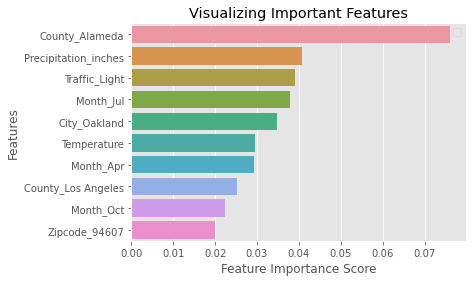

In [58]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [59]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

County_Alameda          0.076121
Precipitation_inches    0.040864
Traffic_Light           0.039103
Month_Jul               0.037881
City_Oakland            0.034839
Temperature             0.029475
Month_Apr               0.029224
County_Los Angeles      0.025146
Month_Oct               0.022386
Zipcode_94607           0.019882
Visibility_miles        0.018786
Zipcode_91355           0.017868
Month_Sep               0.016864
Month_May               0.015996
County_Solano           0.015695
City_Valencia           0.015259
County_Ventura          0.013570
County_Fresno           0.012704
County_Kern             0.012556
Zipcode_94130           0.012431
dtype: float64

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Select the top important features, set the threshold      

In [60]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  5.7min finished


In [61]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=500, random_state=78, verbose=3, max_depth = 10)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   30.0s finished


RandomForestClassifier(max_depth=10, n_estimators=500, random_state=78,
                       verbose=3)

In [62]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[Randon forest algorithm -- Full feature] accuracy_score: 0.815.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.816.


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.3s finished


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Plot the accuracy score versus algorithm

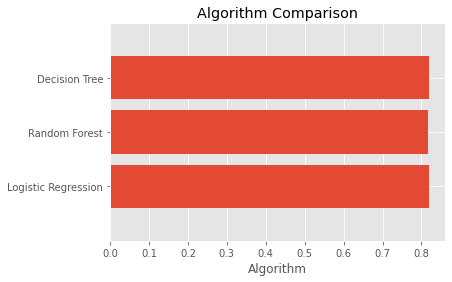

In [63]:
df_graph = pd.read_csv('Accuracy_scores_algorithms_{}.csv')

ax = plt.barh(y=df_graph['Algorithm'],
        width=df_graph['Accuracy_Score'])

# Set the limit, lables, ticks and title
plt.ylim(-1,3)
plt.xlabel('Algorithm')
plt.title('Algorithm Comparison')

plt.show()

In [65]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 1", "Actual 2", "Actual 3", "Actual 4"], 
    columns=["Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4"])

In [66]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)

In [67]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Confusion Matrix


,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 1,0,968,0,0
Actual 2,0,53309,0,0
Actual 3,0,10397,0,0
Actual 4,0,723,0,0


Accuracy Score: 0.8151597168065814
Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       968
           2       0.82      1.00      0.90     53309
           3       0.00      0.00      0.00     10397
           4       0.00      0.00      0.00       723

    accuracy                           0.82     65397
   macro avg       0.20      0.25      0.22     65397
weighted avg       0.66      0.82      0.73     65397



C:\Users\Rob\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
print('Accuracy of logistic regression on training: ', lr.score(X_train_scaled, y_train))
print('Accuracy of logistic regression on testing: ', lr.score(X_test, y_test))

print('Accuracy of random forest on training: ', clf.score(X_train_scaled, y_train))
print('Accuracy of random forest on testing: ', clf.score(X_test, y_test))

print('Accuracy of decision tree on training: ', dt_gini.score(X_train_scaled, y_train))
print('Accuracy of decision tree on testing: ', dt_gini.score(X_test, y_test))

Accuracy of logistic regression on training:  0.5348833653177157
Accuracy of logistic regression on testing:  0.8172240316834105


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.3s finished


Accuracy of random forest on training:  0.814095555572546


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished


Accuracy of random forest on testing:  0.8151597168065814
Accuracy of decision tree on training:  0.8177578310765866
Accuracy of decision tree on testing:  0.8181873786259308


In [69]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [70]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every 1 epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=2740454)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train,callbacks=[cp_callback], epochs=100)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
261586/261586 [==============================] - 43s 165us/sample - loss: -2276963.5429 - acc: 0.0142
Epoch 2/100
261586/261586 [==============================] - 44s 169us/sample - loss: -22928796.1565 - acc: 0.0142
Epoch 3/100
261586/261586 [==============================] - 44s 168us/sample - loss: -80200288.3064 - acc: 0.0142
Epoch 4/100
261586/261586 [==============================] - 41s 156us/sample - loss: -190490920.9922 - acc: 0.0142
Epoch 5/100
261586/261586 [==============================] - 43s 165us/sample - loss: -369543160.4909 - acc: 0.0142
Epoch 6/100
261586/261586 [==============================] - 44s 167us/sample - loss: -633044324.1233 - acc: 0.0142
Epoch 7/100
261586/261586 [==============================] - 42s 162us/sample - loss: -996771885

261586/261586 [==============================] - 38s 144us/sample - loss: -482384166939.1829 - acc: 0.0142
Epoch 58/100
261586/261586 [==============================] - 38s 145us/sample - loss: -507942727766.9664 - acc: 0.0142
Epoch 59/100
261586/261586 [==============================] - 38s 145us/sample - loss: -534371454881.3924 - acc: 0.0142
Epoch 60/100
261586/261586 [==============================] - 38s 144us/sample - loss: -561722559684.9584 - acc: 0.0142
Epoch 61/100
261586/261586 [==============================] - 38s 144us/sample - loss: -589968048530.6069 - acc: 0.0142
Epoch 62/100
261586/261586 [==============================] - 38s 144us/sample - loss: -619171306284.1820 - acc: 0.0142
Epoch 63/100
224384/261586 [========================>.....] - ETA: 5s - loss: -646724939072.6937 - acc: 0.0144
Epoch 00063: saving model to checkpoints/weights.63.hdf5
261586/261586 [==============================] - 38s 144us/sample - loss: -649283258832.7235 - acc: 0.0142
Epoch 64/100
26158

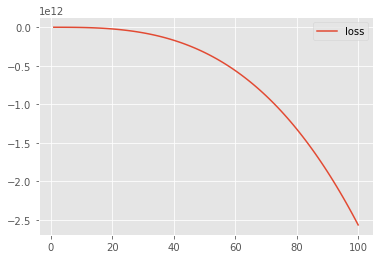

In [71]:
# Plotting graphs
df_plot = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"]) + 1))

df_plot.plot(y="loss")

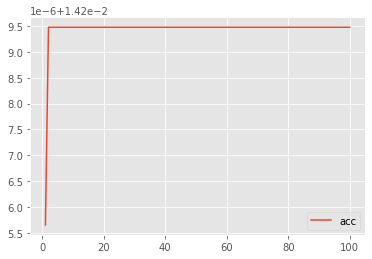

In [72]:
# Plot the loss
df_plot.plot(y="acc")

In [73]:
# Export our model to HDF5 file
nn.save("final_project_nn.h5")